## Mount Google Drive and Link Dataset

In this step, we mount Google Drive to access the dataset stored in the project directory.  
We also create symbolic links to the images folder and the annotations file to make them accessible directly from the Colab environment.


In [5]:
# CELL 1 – Setup Kaggle API, Download Data, & Create Symlinks

import os
import shutil

# 1. Install and set up Kaggle API (assuming kaggle.json is uploaded)
!pip install -q kaggle
!apt-get -qq install -y unzip

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API setup completed.")

# 2. Download and unzip the dataset
DATASET_NAME = 'haaroonafroz/material-dataset-new'
DOWNLOAD_ZIP = 'material-dataset-new.zip'
DESTINATION_FOLDER = 'dataset_raw'

!kaggle datasets download -d {DATASET_NAME}
!unzip -q {DOWNLOAD_ZIP} -d {DESTINATION_FOLDER}

# 3. Define the new local source paths
SOURCE_BASE = os.path.join(DESTINATION_FOLDER, 'Material_dataset')
IMAGES_PATH = os.path.join(SOURCE_BASE, 'JPEGImages')
ANNOTATIONS_PATH = os.path.join(SOURCE_BASE, 'annotations.json')

# 4. Create local symlinks to maintain compatibility with later cells
# The old code relied on these symlinks: /content/images and /content/annotations.json
print("\n=== Creating local symlinks ===")
!ln -s "{IMAGES_PATH}" /content/images
!ln -s "{ANNOTATIONS_PATH}" /content/annotations.json

print("\n✅ Data is ready via Kaggle API!")

Kaggle API setup completed.
Dataset URL: https://www.kaggle.com/datasets/haaroonafroz/material-dataset-new
License(s): apache-2.0
100% 1.24G/1.24G [00:11<00:00, 129MB/s]
100% 1.24G/1.24G [00:11<00:00, 119MB/s]

=== Creating local symlinks ===

✅ Data is ready via Kaggle API!


## Load and Prepare Dataset from Google Drive

In this step, we connect Google Colab to Google Drive in order to access the dataset used for training.  
We then create symbolic links to the images folder and the annotations file so that they can be easily accessed within the Colab environment.  
Finally, we verify that the dataset has been linked correctly by printing the number of images and showing a few sample filenames.


In [6]:
# CELL 2 – Load + Fix Filenames & Class Labels (Critical Preprocessing)

import json, os



# Load annotations

with open('/content/annotations.json', 'r') as f:

    data = json.load(f)['annotations']



print(f"Total annotations: {len(data)}")



# Get real image filenames

real_images = set(os.listdir('/content/images'))



# Fix filenames

fixed = 0

for item in data:

    old = item['image']

    if old.startswith("image_"):

        num = old[6:10]

        mat = old[11] if len(old) >= 12 else 'm'

        new1 = f"rendered_image_{num}_{mat}.jpg"

        new2 = f"rendered_image_{num}_mx.jpg"

        if new1 in real_images:

            item['image'] = new1

            fixed += 1

        elif new2 in real_images:

            item['image'] = new2

            fixed += 1



# Normalize class labels

for item in data:

    label = item['class_label'].lower()

    if label in ['mix', 'mx', 'mixed']:

        item['class_label'] = 'mixed'



print(f"Fixed {fixed}/{len(data)} image names")



# Define class mapping

classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

class_to_idx = {c: i for i, c in enumerate(classes)}

idx_to_class = {i: c for i, c in enumerate(classes)}



print("Classes:", classes)

Total annotations: 20000
Fixed 14000/20000 image names
Classes: ['glass', 'metal', 'mixed', 'plastic', 'wood']


## Visualizing Sample Images from the Dataset

In this step, we randomly select a few samples from the dataset and display them using Matplotlib.  
This helps verify that the images are loaded correctly and that the class labels match the corresponding files before training the model.




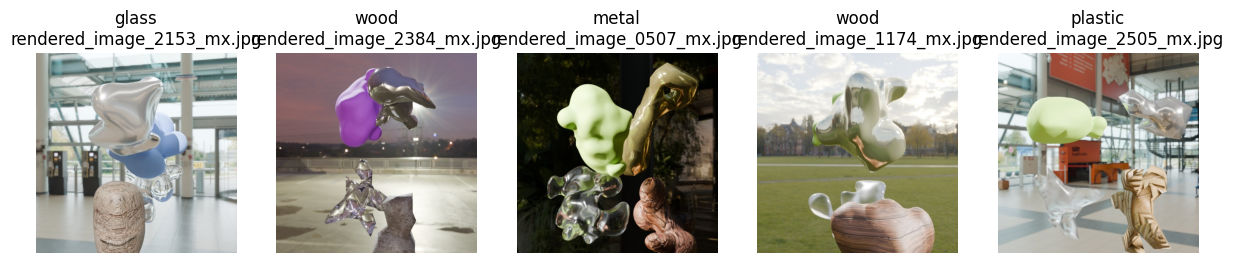

In [8]:
# CELL 3 – Show Sample Data

import random

import matplotlib.pyplot as plt

from PIL import Image



# Random sample

sample = random.sample(data, 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))



for ax, item in zip(axes, sample):

    img_path = os.path.join('/content/images', item['image'])

    img = Image.open(img_path)

    ax.imshow(img)

    ax.set_title(f"{item['class_label']}\n{item['image']}")

    ax.axis('off')



plt.show()

## Data Cleaning & Verification (Post-Preprocessing)

In this step, we analyze and clean the dataset after preprocessing to ensure data consistency and integrity.

### This cell performs the following tasks:

1. Convert the annotations into a Pandas DataFrame for easier analysis.
2. Check the class distribution to understand dataset balance.
3. Identify:
   - Images that exist without annotations.
   - Annotations that reference missing images.
4. Remove invalid entries where annotation does not have a corresponding image.
5. Recalculate and visualize the cleaned class distribution.
6. Update the `data` variable with the cleaned dataset.

A bar chart is also displayed to show the final class distribution after data cleaning.


DATA CLEANING & VERIFICATION

1. CLASS DISTRIBUTION:
class_label
mixed      6000
metal      3500
glass      3500
plastic    3500
wood       3500
Name: count, dtype: int64
----------------------------------------

2. IMAGES WITHOUT ANNOTATIONS: 14001
ANNOTATIONS WITHOUT IMAGES: 0

3. CLEANING DATA...
Total annotations before cleaning: 20000
Total annotations after cleaning: 20000

4. CLEANED CLASS DISTRIBUTION:
class_label
mixed      6000
metal      3500
glass      3500
plastic    3500
wood       3500
Name: count, dtype: int64


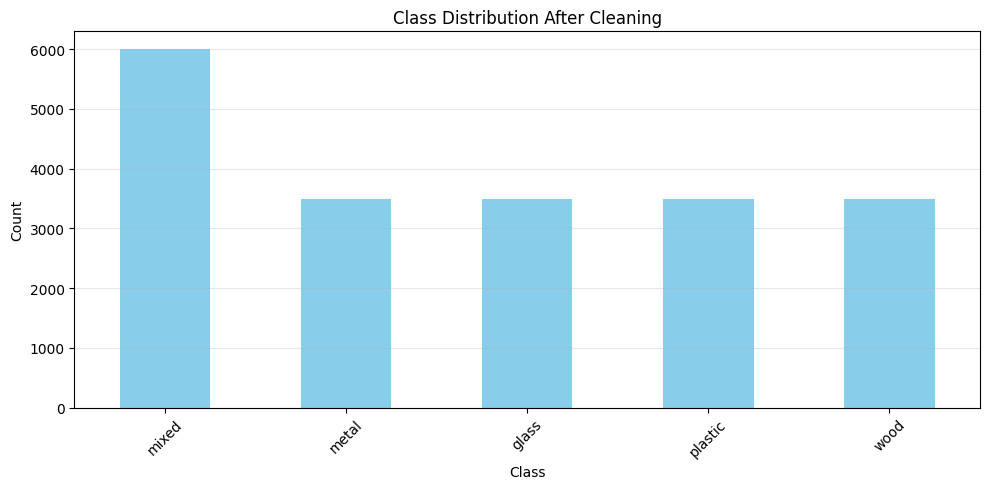


5. FINAL DATASET INFO:
Total images: 20001
Total annotations: 20000
Classes: ['mixed', 'metal', 'glass', 'plastic', 'wood']
Class counts: {'mixed': 6000, 'metal': 3500, 'glass': 3500, 'plastic': 3500, 'wood': 3500}


In [9]:
# CELL 4 – Data Cleaning & Verification (Post-Preprocessing)

import pandas as pd

import matplotlib.pyplot as plt



print("="*60)

print("DATA CLEANING & VERIFICATION")

print("="*60)



# Convert annotations to DataFrame for easier analysis

df = pd.DataFrame(data)



# 1. Check class distribution

print("\n1. CLASS DISTRIBUTION:")

print(df['class_label'].value_counts())

print("-"*40)



# 2. Find mismatches between images and annotations

fixed_images = set(df['image'])

real_images = set(os.listdir('/content/images'))



# Images without annotations

images_without_annots = real_images - fixed_images

print(f"\n2. IMAGES WITHOUT ANNOTATIONS: {len(images_without_annots)}")



# Annotations without corresponding images

annots_without_images = [img for img in df['image'] if img not in real_images]

print(f"ANNOTATIONS WITHOUT IMAGES: {len(annots_without_images)}")



if annots_without_images:

    print(f"Sample missing images: {annots_without_images[:5]}")



# 3. Remove annotations without images

print(f"\n3. CLEANING DATA...")

print(f"Total annotations before cleaning: {len(df)}")



# Remove rows where image doesn't exist

df_clean = df[df['image'].isin(real_images)].copy()

print(f"Total annotations after cleaning: {len(df_clean)}")



# 4. Check cleaned distribution

print(f"\n4. CLEANED CLASS DISTRIBUTION:")

class_dist = df_clean['class_label'].value_counts()

print(class_dist)



# Visualize distribution

plt.figure(figsize=(10, 5))

class_dist.plot(kind='bar', color='skyblue')

plt.title('Class Distribution After Cleaning')

plt.xlabel('Class')

plt.ylabel('Count')

plt.xticks(rotation=45)

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

plt.show()



# 5. Update data with cleaned version

data = df_clean.to_dict('records')



print(f"\n5. FINAL DATASET INFO:")

print(f"Total images: {len(real_images)}")

print(f"Total annotations: {len(data)}")

print(f"Classes: {list(class_dist.index)}")

print(f"Class counts: {class_dist.to_dict()}")

print("="*60)

## Train–Validation–Test Split

After cleaning and verifying the dataset, this step divides the images into three separate subsets:

### 1. Training Set
Used to train the CNN model.

### 2. Validation Set
Used to tune hyperparameters and monitor performance during training to prevent overfitting.

### 3. Test Set
Used to evaluate the final model after training is complete.

### This cell performs the following:
- Builds lists of `image_paths` and numerical `labels`.
- Applies stratified splitting using `train_test_split` to preserve class balance.
- Saves the split into a `dataset_split.pkl` file for reproducibility.
- Prints detailed statistics including:
  - Percentages of train/validation/test sets
  - Class distribution per split

This ensures a well-balanced and reproducible dataset split for training deep learning models.


In [10]:
from sklearn.model_selection import train_test_split

import numpy as np

import pickle



image_paths = []

labels = []



for item in data:

    img_path = os.path.join('/content/images', item['image'])

    if os.path.exists(img_path):

        image_paths.append(img_path)

        labels.append(class_to_idx[item['class_label'].lower()])



X_temp, X_test, y_temp, y_test = train_test_split(

    image_paths, labels,

    test_size=0.15,

    stratify=labels,

    random_state=42

)



X_train, X_val, y_train, y_val = train_test_split(

    X_temp, y_temp,

    test_size=0.1765,

    stratify=y_temp,

    random_state=42

)



import pickle

split_data = {

    'X_train': X_train, 'y_train': y_train,

    'X_val': X_val, 'y_val': y_val,

    'X_test': X_test, 'y_test': y_test,

    'classes': classes,

    'class_to_idx': class_to_idx,

    'idx_to_class': idx_to_class

}



# حفظ في ملف

with open('/content/dataset_split.pkl', 'wb') as f:

    pickle.dump(split_data, f)



print("✅ Split saved to '/content/dataset_split.pkl'")





def load_split():

    with open('/content/dataset_split.pkl', 'rb') as f:

        split_data = pickle.load(f)

    return split_data



print("\n📌 To load this split later, use:")

print("split_data = load_split()")

print("X_train, y_train = split_data['X_train'], split_data['y_train']")





print(f"\n✅ Split completed!")

print(f"Total images: {len(image_paths)}")

print(f"Train: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")

print(f"Validation: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")

print(f"Test: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")



from collections import Counter

print("\nClass distribution:")

print(f"Train: {Counter(y_train)}")

print(f"Val: {Counter(y_val)}")

print(f"Test: {Counter(y_test)}")

✅ Split saved to '/content/dataset_split.pkl'

📌 To load this split later, use:
split_data = load_split()
X_train, y_train = split_data['X_train'], split_data['y_train']

✅ Split completed!
Total images: 20000
Train: 13999 (70.0%)
Validation: 3001 (15.0%)
Test: 3000 (15.0%)

Class distribution:
Train: Counter({2: 4199, 3: 2450, 1: 2450, 4: 2450, 0: 2450})
Val: Counter({2: 901, 0: 525, 3: 525, 4: 525, 1: 525})
Test: Counter({2: 900, 0: 525, 1: 525, 3: 525, 4: 525})


## Organizing Dataset Folders

This step organizes the dataset into structured folders by class for training and validation.  
Each split (`train` and `val`) will have subfolders for each class (`glass`, `metal`, `mixed`, `plastic`, `wood`).  

Images are copied to their corresponding class folders, and a progress bar shows the copy status.  
At the end, the number of images per split and class distribution are printed to verify the dataset organization.

This structure is required for most deep learning data loaders and ensures a clean, reproducible workflow.


In [11]:
import os

import shutil

from tqdm import tqdm



print("="*60)

print("CREATING ORGANIZED FOLDERS")

print("="*60)

if 'idx_to_class' not in locals():

    classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

    idx_to_class = {i: c for i, c in enumerate(classes)}



def create_folders(X_split, y_split, split_name):

    base_path = f"/content/data/{split_name}"



    for class_name in classes:

        os.makedirs(os.path.join(base_path, class_name), exist_ok=True)



    copied = 0

    for img_path, label_idx in tqdm(zip(X_split, y_split),

                                    total=len(X_split),

                                    desc=f"Copying {split_name}"):

        try:

            class_name = idx_to_class[label_idx]

            filename = os.path.basename(img_path)

            dest_path = os.path.join(base_path, class_name, filename)

            shutil.copy2(img_path, dest_path)

            copied += 1

        except Exception as e:

            print(f"Error: {img_path} → {e}")



    print(f"✅ {split_name}: {copied}/{len(X_split)} images")

    print(f"\n{split_name} class distribution:")

    for class_name in classes:

        count = len(os.listdir(os.path.join(base_path, class_name)))

        print(f"  {class_name}: {count}")

    print()



    return base_path

os.makedirs("/content/data", exist_ok=True)



train_base = create_folders(X_train, y_train, "train")

val_base = create_folders(X_val, y_val, "val")



print("="*60)

print("FOLDERS CREATED SUCCESSFULLY!")

print("="*60)

print(f"📁 Train: {train_base}")

print(f"📁 Val: {val_base}")

print(f"📁 Test: Will be used from variables (X_test, y_test)")



CREATING ORGANIZED FOLDERS


Copying train: 100%|██████████| 13999/13999 [00:05<00:00, 2351.00it/s]


✅ train: 13999/13999 images

train class distribution:
  glass: 2450
  metal: 2450
  mixed: 4199
  plastic: 2450
  wood: 2450



Copying val: 100%|██████████| 3001/3001 [00:01<00:00, 2590.68it/s]

✅ val: 3001/3001 images

val class distribution:
  glass: 525
  metal: 525
  mixed: 901
  plastic: 525
  wood: 525

FOLDERS CREATED SUCCESSFULLY!
📁 Train: /content/data/train
📁 Val: /content/data/val
📁 Test: Will be used from variables (X_test, y_test)


## Data Augmentation and DataLoaders

In this step, we prepare the dataset for training by applying transformations and creating PyTorch DataLoaders.

### Transformations:

- **Training set**: Random resized crop, horizontal flip, rotation, color jitter, normalization.  
- **Validation set**: Resize and normalization only (no augmentation).

### DataLoaders:

- `train_loader` and `val_loader` are created with a batch size of 32.  
- Shuffling is enabled for training to improve generalization.  
- These DataLoaders will feed batches of images to the CNN during training and validation.

This step ensures that the model sees augmented data during training while evaluation is done on consistent, normalized images.


In [12]:
import torch

from torch.utils.data import DataLoader

from torchvision import datasets, transforms



# Transformations

train_transform_advanced = transforms.Compose([

    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomRotation(degrees=15),

    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])



val_test_transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])



train_dataset = datasets.ImageFolder(

    root='/content/data/train',

    transform=train_transform_advanced

)



val_dataset = datasets.ImageFolder(

    root='/content/data/val',

    transform=val_test_transform

)



classes = train_dataset.classes

class_to_idx = train_dataset.class_to_idx

idx_to_class = {v: k for k, v in class_to_idx.items()}



print(f"✅ Classes detected: {classes}")

print(f"✅ Class to index: {class_to_idx}")



# DataLoaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)



print(f"\n✅ DataLoaders created:")

print(f"  Train: {len(train_dataset)} samples")

print(f"  Validation: {len(val_dataset)} samples")

✅ Classes detected: ['glass', 'metal', 'mixed', 'plastic', 'wood']
✅ Class to index: {'glass': 0, 'metal': 1, 'mixed': 2, 'plastic': 3, 'wood': 4}

✅ DataLoaders created:
  Train: 13999 samples
  Validation: 3001 samples


## Creating PyTorch DataLoaders

In this step, we define a custom PyTorch `Dataset` class (`MaterialDataset`) to handle our images and labels.  
We also create DataLoaders for training, validation, and testing.

### Key Points:

- **Custom Dataset**:
  - Loads images from paths and applies optional transformations.
  - Returns a tuple `(image, label)` for each sample.

- **Transformations**:
  - **Training**: Random resized crop, horizontal flip, rotation, color jitter, normalization.
  - **Validation/Test**: Resize to 224×224 and normalization only.

- **DataLoaders**:
  - `train_loader` with shuffling for better generalization.
  - `val_loader` and `test_loader` without shuffling.
  - Batch size = 32.

These DataLoaders provide batches of images and labels to feed the CNN during training and evaluation.


In [13]:
# CELL 7 – Create PyTorch DataLoader

import torch

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, datasets

from PIL import Image



class MaterialDataset(Dataset):

    def __init__(self, image_paths, labels, transform=None):

        self.image_paths = image_paths

        self.labels = labels

        self.transform = transform



    def __len__(self):

        return len(self.image_paths)



    def __getitem__(self, idx):

        img_path = self.image_paths[idx]

        image = Image.open(img_path).convert('RGB')

        label = self.labels[idx]



        if self.transform:

            image = self.transform(image)



        return image, label



# Transformations

train_transform = transforms.Compose([

    transforms.RandomResizedCrop(224),

    transforms.RandomHorizontalFlip(),

    transforms.RandomRotation(10),

    transforms.ColorJitter(brightness=0.2, contrast=0.2),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])



val_test_transform = transforms.Compose([

    transforms.Resize((224, 224)),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])



# Create datasets

train_dataset = MaterialDataset(X_train, y_train, transform=train_transform)

val_dataset = MaterialDataset(X_val, y_val, transform=val_test_transform)

test_dataset = MaterialDataset(X_test, y_test, transform=val_test_transform)



# DataLoaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



print("DataLoaders created successfully.")

DataLoaders created successfully.


## Advanced Data Augmentation with torchvision

In this step, we enhance the training dataset using advanced augmentation techniques to improve model robustness, especially for texture and lighting variations.

### Key Points:

- **Advanced Augmentations for Training:**
  - Random resized crop, horizontal flip, rotation
  - Color jitter (brightness, contrast, saturation, hue)
  - Sharpness adjustment, autocontrast, grayscale
  - Gaussian blur
  - Simulated Gaussian noise

- **Validation/Test:**  
  Only resize and normalization, no augmentation.

- **Custom Dataset Class (`MaterialDataset`):**  
  - Loads images and applies the chosen transformations
  - Handles errors gracefully by returning a dummy image if loading fails

- **DataLoaders:**  
  - `train_aug_loader` with shuffling for training  
  - `val_aug_loader` and `test_aug_loader` without shuffling  
  - Batch size = 32

These augmentations help the CNN model generalize better under varying lighting, texture, and industrial noise conditions.


In [14]:
# CELL 8 – Advanced Augmentation using torchvision (WORKING VERSION)

import torch

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms

from PIL import Image

import numpy as np

import random

import os



print("Setting up advanced augmentation pipeline using torchvision...")



def get_advanced_torchvision_augmentations():



    return transforms.Compose([

        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

        transforms.RandomHorizontalFlip(p=0.5),

        transforms.RandomRotation(degrees=15),



        # Lighting variations (BONUS FOCUS)

        transforms.ColorJitter(

            brightness=0.3,    # ±30% brightness variation

            contrast=0.3,      # ±30% contrast variation

            saturation=0.2,    # ±20% saturation

            hue=0.1           # ±10% hue

        ),



        # Advanced augmentations for texture robustness

        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),

        transforms.RandomAutocontrast(p=0.3),

        transforms.RandomGrayscale(p=0.1),



        # Simulate shadows and blur

        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),



        # Convert to tensor

        transforms.ToTensor(),



        # Normalize (ImageNet stats)

        transforms.Normalize(mean=[0.485, 0.456, 0.406],

                           std=[0.229, 0.224, 0.225]),



        # Add simulated noise for industrial conditions

        transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05),  # Gaussian noise

    ])



def get_basic_transform():



    return transforms.Compose([

        transforms.Resize((224, 224)),

        transforms.ToTensor(),

        transforms.Normalize(mean=[0.485, 0.456, 0.406],

                           std=[0.229, 0.224, 0.225]),

    ])



# Dataset Class

class MaterialDataset(Dataset):

    def __init__(self, image_paths, labels, transform=None):

        self.image_paths = image_paths

        self.labels = labels

        self.transform = transform



    def __len__(self):

        return len(self.image_paths)



    def __getitem__(self, idx):

        img_path = self.image_paths[idx]

        try:

            image = Image.open(img_path).convert('RGB')

            label = self.labels[idx]



            if self.transform:

                image = self.transform(image)



            return image, label

        except Exception as e:

            print(f"Error loading image {img_path}: {e}")

            # Return a dummy image if there's an error

            dummy_img = torch.zeros((3, 224, 224))

            return dummy_img, 0





train_transform_advanced = get_advanced_torchvision_augmentations()

val_transform = get_basic_transform()

test_transform = get_basic_transform()

print(f"\nData info:")

print(f"X_train: {len(X_train)} samples")

print(f"X_val: {len(X_val)} samples")

print(f"X_test: {len(X_test)} samples")

train_aug_dataset = MaterialDataset(X_train, y_train, transform=train_transform_advanced)

val_aug_dataset = MaterialDataset(X_val, y_val, transform=val_transform)

test_aug_dataset = MaterialDataset(X_test, y_test, transform=test_transform)

train_aug_loader = DataLoader(train_aug_dataset, batch_size=32, shuffle=True, num_workers=2)

val_aug_loader = DataLoader(val_aug_dataset, batch_size=32, shuffle=False, num_workers=2)

test_aug_loader = DataLoader(test_aug_dataset, batch_size=32, shuffle=False, num_workers=2)



print(f"\n✓ Datasets created successfully!")

print(f"  Train dataset: {len(train_aug_dataset)} samples")

print(f"  Validation dataset: {len(val_aug_dataset)} samples")

print(f"  Test dataset: {len(test_aug_dataset)} samples")

print(f"  Classes: {classes}")

Setting up advanced augmentation pipeline using torchvision...

Data info:
X_train: 13999 samples
X_val: 3001 samples
X_test: 3000 samples

✓ Datasets created successfully!
  Train dataset: 13999 samples
  Validation dataset: 3001 samples
  Test dataset: 3000 samples
  Classes: ['glass', 'metal', 'mixed', 'plastic', 'wood']


## Visualizing Augmented Samples

In this step, we visualize the effect of advanced augmentations on the training images to ensure that the transformations are applied correctly.

### Key Points:

- **Original vs Augmented Images:**  
  Each sample is displayed in two rows:
  - Top row: original image
  - Bottom row: augmented image

- **Augmentations Visualized Include:**  
  - Random resized crop, color jitter, horizontal flip, rotation  
  - Lighting and texture variations  
  - Gaussian blur, noise, sharpness adjustments

- **Purpose:**  
  - Verify that augmentation preserves the class label
  - Ensure diversity in training data to improve texture robustness under varying lighting and industrial conditions

- **Implementation:**  
  - Randomly select a few samples from the training dataset
  - Display side-by-side comparisons using Matplotlib


Lighting & Texture Augmentation

Visualizing 5 augmented samples...


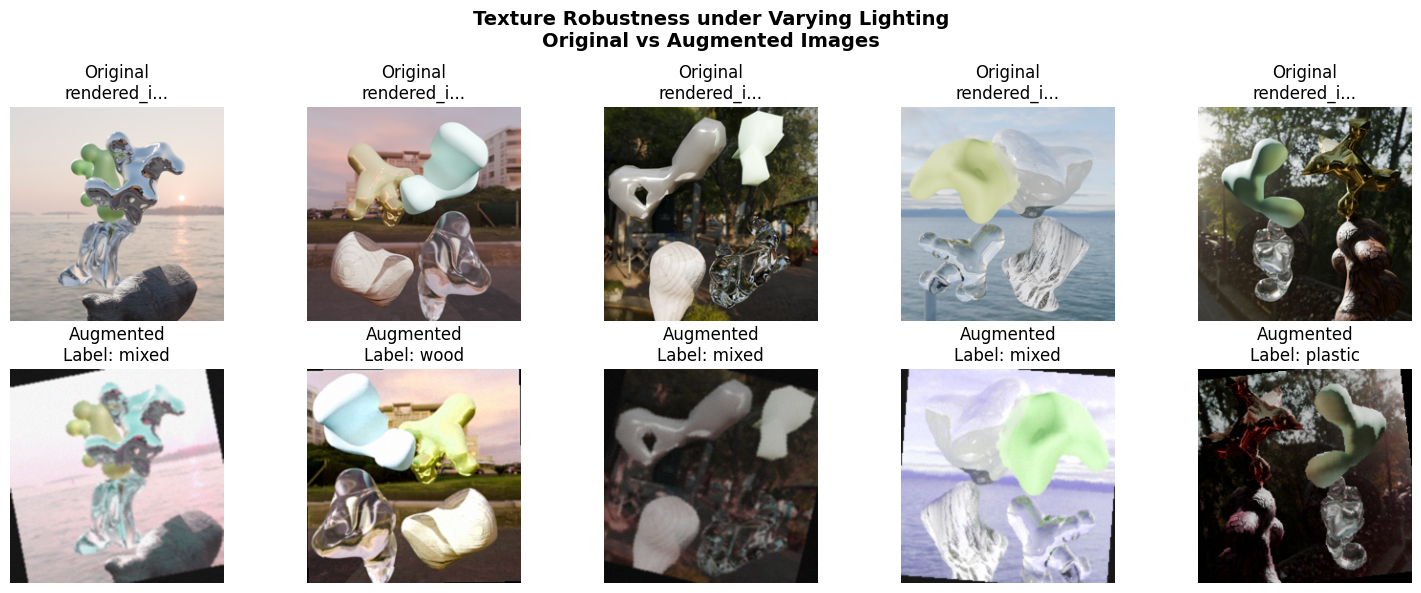

✓ Visualization completed!


In [15]:
# CELL 9 – Visualize Augmented Samples

import matplotlib.pyplot as plt

import random

import numpy as np

import os

from PIL import Image

import torch

if 'idx_to_class' not in locals():

    classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

    idx_to_class = {i: c for i, c in enumerate(classes)}



if 'idx_to_class' not in locals():

    classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

    idx_to_class = {i: c for i, c in enumerate(classes)}



def visualize_augmentations(dataset, num_samples=5):

    print(f"\nVisualizing {num_samples} augmented samples...")



    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))



    for i, idx in enumerate(indices):

        img_path = dataset.image_paths[idx]

        try:

            # Original image

            orig_img = Image.open(img_path).convert('RGB')

            orig_img_resized = orig_img.resize((224, 224))

            axes[0, i].imshow(orig_img_resized)

            axes[0, i].set_title(f"Original\n{os.path.basename(img_path)[:10]}...")

            axes[0, i].axis('off')



            # Augmented image

            aug_img, label = dataset[idx]



            if isinstance(aug_img, torch.Tensor):

                if aug_img.shape[0] == 3:

                    img_display = aug_img.clone()

                    img_display = img_display.permute(1, 2, 0).cpu().numpy()

                    img_display = np.clip(

                        img_display * np.array([0.229, 0.224, 0.225]) +

                        np.array([0.485, 0.456, 0.406]),

                        0, 1

                    )

                else:

                    img_display = np.zeros((224, 224, 3))

            else:

                img_display = aug_img



            axes[1, i].imshow(img_display)

            axes[1, i].set_title(f"Augmented\nLabel: {idx_to_class[label]}")

            axes[1, i].axis('off')



        except Exception as e:

            print(f"  Error with sample {idx}: {e}")

            axes[0, i].text(0.5, 0.5, "Error", ha='center', va='center')

            axes[1, i].text(0.5, 0.5, "Error", ha='center', va='center')

            axes[0, i].axis('off')

            axes[1, i].axis('off')



    plt.suptitle("Texture Robustness under Varying Lighting\nOriginal vs Augmented Images",

                 fontsize=14, fontweight='bold')

    plt.tight_layout()

    plt.show()

    print("✓ Visualization completed!")



print("=" * 60)

print("Lighting & Texture Augmentation")

print("=" * 60)



if 'train_aug_dataset' in locals() and len(train_aug_dataset) > 0:

    visualize_augmentations(train_aug_dataset, 5)

else:

    print("Creating emergency dataset...")



    class MaterialDataset:

        def __init__(self, image_paths, labels, transform=None):

            self.image_paths = image_paths

            self.labels = labels

            self.transform = transform

        def __len__(self): return len(self.image_paths)

        def __getitem__(self, idx):

            img = Image.open(self.image_paths[idx]).convert('RGB')

            if self.transform: img = self.transform(img)

            return img, self.labels[idx]



    from torchvision import transforms

    train_transform_advanced = transforms.Compose([

        transforms.RandomResizedCrop(224),

        transforms.ColorJitter(brightness=0.3, contrast=0.3),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])



    train_aug_dataset = MaterialDataset(X_train[:50], y_train[:50], transform=train_transform_advanced)

    visualize_augmentations(train_aug_dataset, min(5, len(train_aug_dataset)))

## Final Check: Class Distribution & DataLoader Test

In this step, we perform a final verification to ensure that:

1. **Class Distribution**  
   - Count the number of samples per class in the training, validation, and test splits.  
   - Verify that the data is balanced and correctly split.

2. **DataLoader Functionality**  
   - Load a single batch from `train_aug_loader` to check shapes and values.  
   - Print the batch size, image tensor shape, labels, and sample class names.  
   - Confirm that image normalization and augmentations are correctly applied.

This final check ensures the dataset is ready and the DataLoaders are working properly before training the CNN model.


In [16]:
# CELL 10 – Final Check: Class Distribution & DataLoader Test

import collections



if 'idx_to_class' not in locals():

    classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

    idx_to_class = {i: c for i, c in enumerate(classes)}



if 'idx_to_class' not in locals():

    classes = ['glass', 'metal', 'mixed', 'plastic', 'wood']

    idx_to_class = {i: c for i, c in enumerate(classes)}



# 1. Check class distribution in splits

def check_class_distribution(labels, split_name):

    print(f"\n{split_name} Class Distribution:")

    label_counts = collections.Counter(labels)

    for class_idx, count in label_counts.items():

        class_name = idx_to_class[class_idx]

        print(f"  {class_name}: {count} samples")

    print(f"  Total: {len(labels)} samples")



check_class_distribution(y_train, "TRAIN")

check_class_distribution(y_val, "VALIDATION")

check_class_distribution(y_test, "TEST")



# 2. Test DataLoader

print("\n" + "="*60)

print("Testing DataLoader...")

print("="*60)



try:

    for batch_idx, (images, labels) in enumerate(train_aug_loader):

        print(f"Batch {batch_idx+1}:")

        print(f"  Images shape: {images.shape}")

        print(f"  Labels shape: {labels.shape}")

        print(f"  Labels: {labels[:5].tolist()} ({[idx_to_class[l.item()] for l in labels[:5]]})")

        print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")

        break

    print("\n✅ DataLoader is working correctly!")

except Exception as e:

    print(f"\n❌ Error in DataLoader: {e}")


TRAIN Class Distribution:
  plastic: 2450 samples
  metal: 2450 samples
  mixed: 4199 samples
  wood: 2450 samples
  glass: 2450 samples
  Total: 13999 samples

VALIDATION Class Distribution:
  glass: 525 samples
  plastic: 525 samples
  mixed: 901 samples
  wood: 525 samples
  metal: 525 samples
  Total: 3001 samples

TEST Class Distribution:
  mixed: 900 samples
  glass: 525 samples
  metal: 525 samples
  plastic: 525 samples
  wood: 525 samples
  Total: 3000 samples

Testing DataLoader...
Batch 1:
  Images shape: torch.Size([32, 3, 224, 224])
  Labels shape: torch.Size([32])
  Labels: [0, 0, 1, 2, 3] (['glass', 'glass', 'metal', 'mixed', 'plastic'])
  Image range: [-2.337, 2.846]

✅ DataLoader is working correctly!
